In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs
from pathlib import Path
import os
import seaborn as sns

DATA_PATH = R"C:\Users\chiar\OneDrive - epfl.ch\ADA\Project\Dataset"
DATA_PATH = Path(os.path.expandvars(DATA_PATH))

#### Data load and separation in "keep_fame" and "lose_fame" populations

In [2]:
# channels_df separated in "keep_fame" and "lose_fame" after matching
keep_fame = pd.read_csv(DATA_PATH / "keep_fame_after_matching.tsv.gz", compression='gzip', sep = '\t')
lose_fame = pd.read_csv(DATA_PATH / "lose_fame_after_matching.tsv.gz", compression='gzip', sep = '\t')

In [3]:
keep_fame.shape

(163, 14)

In [4]:
lose_fame.shape

(163, 14)

In [5]:
keep_fame.columns

Index(['category_cc', 'join_date', 'channel', 'name_cc', 'subscribers_cc',
       'videos_cc', 'subscriber_rank_sb', 'weights', 'growth_steepness',
       'growth', 'variability', 'growth_rate', 'keep_fame',
       'propensity_score'],
      dtype='object')

In [6]:
# timeseries_df loading and separation in "keep_fame" and "lose_fame" after matching
timeseries_df = pd.read_csv(DATA_PATH / "timeseries_df_filtered.tsv.gz", compression='gzip', sep = '\t', parse_dates=['datetime', 'max_growth_date'])
keep_fame_ts = timeseries_df[timeseries_df['channel'].isin(keep_fame['channel'])]
lose_fame_ts = timeseries_df[timeseries_df['channel'].isin(lose_fame['channel'])]

In [7]:
timeseries_df.groupby("channel").count().shape

(2150, 16)

In [8]:
len(keep_fame_ts.groupby("channel")), len(lose_fame_ts.groupby("channel"))

(163, 163)

In [9]:
# metavideos df loading and separation between lose and keep fame
meta_video_filt_original = pd.read_csv(DATA_PATH / "videos_metadata_filtered_population.tsv.gz", sep='\t', compression='gzip')

# checked that there is a video without category, so we remove it
meta_video_filt_original = meta_video_filt_original.drop(meta_video_filt_original[meta_video_filt_original["categories"].isna()].index, axis=0)

# we remove the videos that are not in the two populations
keep_fame_metavideos = meta_video_filt_original[meta_video_filt_original['channel_id'].isin(keep_fame['channel'])]
lose_fame_metavideos = meta_video_filt_original[meta_video_filt_original['channel_id'].isin(lose_fame['channel'])]

In [10]:
# metavideos dfs with max growth date
keep_fame_metavideos = keep_fame_metavideos.merge(keep_fame_ts.groupby('channel')['max_growth_date'].max(), left_on='channel_id', right_on='channel')
lose_fame_metavideos = lose_fame_metavideos.merge(lose_fame_ts.groupby('channel')['max_growth_date'].max(), left_on='channel_id', right_on='channel')

In [11]:
keep_fame_metavideos.groupby('channel_id').count().shape

(163, 13)

#### Dataframe separation between before and after growth date

<font color = 'green'> **TO DO**

In [12]:
matched_channels = pd.read_csv(DATA_PATH / "matched_channels.tsv.gz", compression='gzip', sep = '\t')

In [13]:
# keep and lose metavideos dfs divided before and after max growth date
keep_metavideos_after_sudden_growth = keep_fame_metavideos[keep_fame_metavideos["upload_date"] > keep_fame_metavideos["max_growth_date"]].copy()
lose_metavideos_after_sudden_growth = lose_fame_metavideos[lose_fame_metavideos["upload_date"] > lose_fame_metavideos["max_growth_date"]].copy()
keep_metavideos_before_sudden_growth = keep_fame_metavideos[keep_fame_metavideos["upload_date"] <= keep_fame_metavideos["max_growth_date"]].copy()
lose_metavideos_before_sudden_growth = lose_fame_metavideos[lose_fame_metavideos["upload_date"] <= lose_fame_metavideos["max_growth_date"]].copy()


In [14]:
# filter video data of "keep" channels that have videos both before sudden growth and after sudden growth
channels_k_b = keep_metavideos_before_sudden_growth["channel_id"].unique()
channels_k_a = keep_metavideos_after_sudden_growth["channel_id"].unique()
index_keep = set.intersection(set(channels_k_b), set(channels_k_a))

print(f"Number of keep fame channels selected: {index_keep.__len__()}")

keep_metavideos_before_sudden_growth = keep_metavideos_before_sudden_growth[keep_metavideos_before_sudden_growth["channel_id"].isin(index_keep)]
keep_metavideos_after_sudden_growth = keep_metavideos_after_sudden_growth[keep_metavideos_after_sudden_growth["channel_id"].isin(index_keep)]


Number of keep fame channels selected: 155


In [15]:
# filter video data of "lose" channels that have videos both before sudden growth and after sudden growth
channels_l_b = lose_metavideos_before_sudden_growth["channel_id"].unique()
channels_l_a = lose_metavideos_after_sudden_growth["channel_id"].unique()
index_lose = set.intersection(set(channels_l_b), set(channels_l_a))

print(f"Number of lose fame channels selected: {index_lose.__len__()}")

lose_metavideos_before_sudden_growth = lose_metavideos_before_sudden_growth[lose_metavideos_before_sudden_growth["channel_id"].isin(index_lose)]
lose_metavideos_after_sudden_growth = lose_metavideos_after_sudden_growth[lose_metavideos_after_sudden_growth["channel_id"].isin(index_lose)]

Number of lose fame channels selected: 138


In [16]:
# remove channels that don't have a match anymore
removed_keep = matched_channels[~matched_channels["channel_keep"].isin(index_keep)]
removed_lose = matched_channels[~matched_channels["channel_lose"].isin(index_lose)]
index_remove = set.union(set(removed_keep["channel_lose"]), set(removed_lose["channel_keep"]))

keep_metavideos_after_sudden_growth = keep_metavideos_after_sudden_growth[~keep_metavideos_after_sudden_growth["channel_id"].isin(index_remove)]
keep_metavideos_before_sudden_growth = keep_metavideos_before_sudden_growth[~keep_metavideos_before_sudden_growth["channel_id"].isin(index_remove)]
lose_metavideos_after_sudden_growth = lose_metavideos_after_sudden_growth[~lose_metavideos_after_sudden_growth["channel_id"].isin(index_remove)]
lose_metavideos_before_sudden_growth = lose_metavideos_before_sudden_growth[~lose_metavideos_before_sudden_growth["channel_id"].isin(index_remove)]


In [17]:
print(f"Number of channels selected per group: {lose_metavideos_after_sudden_growth['channel_id'].unique().__len__()}")

Number of channels selected per group: 132


In [18]:
# filter timeseries data of "keep" and "lose" channels that have videos both before sudden growth and after sudden growth
keep_fame_ts = keep_fame_ts[keep_fame_ts["channel"].isin(keep_metavideos_after_sudden_growth['channel_id'])]
lose_fame_ts = lose_fame_ts[lose_fame_ts["channel"].isin(lose_metavideos_after_sudden_growth['channel_id'])]


In [19]:
keep_fame_channels = keep_fame[keep_fame["channel"].isin(keep_metavideos_after_sudden_growth['channel_id'])]
lose_fame_channels = lose_fame[lose_fame["channel"].isin(lose_metavideos_after_sudden_growth['channel_id'])]

In [20]:
cat_distr_for_plotting = pd.concat([keep_fame_channels.groupby("category_cc").count()["name_cc"], lose_fame_channels.groupby("category_cc").count()["join_date"]], axis=1)\
    .rename(columns={"name_cc":"keep", "join_date":"lose"})

cat_distr_for_plotting.reset_index(inplace=True)
cat_distr_for_plotting = cat_distr_for_plotting.melt('category_cc', var_name='population', value_name='vals')


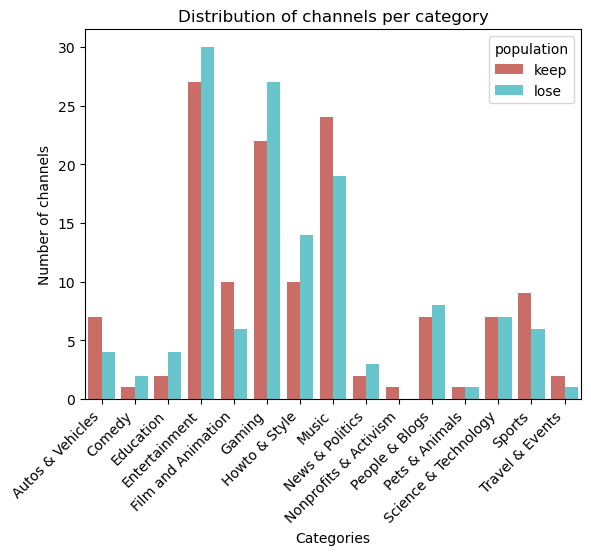

In [21]:
sns.barplot(data=cat_distr_for_plotting, x="category_cc", y='vals', hue="population", palette="hls")
plt.xticks(rotation=45, ha="right");
plt.xlabel("Categories");
plt.ylabel("Number of channels");
plt.title("Distribution of channels per category");

### Analysis

<font color = 'green'> **TO DO**

##### Frequency of publication

In [22]:
# compute number of videos posted by each channel before and after sudden growth
keep_num_metavideos_per_channel_after_sudden_growth = keep_metavideos_after_sudden_growth.groupby("channel_id").count()["duration"]
keep_num_metavideos_per_channel_before_sudden_growth = keep_metavideos_before_sudden_growth.groupby("channel_id").count()["duration"]
lose_num_metavideos_per_channel_after_sudden_growth = lose_metavideos_after_sudden_growth.groupby("channel_id").count()["duration"]
lose_num_metavideos_per_channel_before_sudden_growth = lose_metavideos_before_sudden_growth.groupby("channel_id").count()["duration"]

In [23]:
# compute time of observation of each channel before and after sudden growth
keep_videos_time_after_sudden_growth = (keep_fame_ts.groupby("channel")["datetime"].max() - keep_fame_ts.groupby("channel")["max_growth_date"].mean()).dt.days
lose_videos_time_after_sudden_growth = (lose_fame_ts.groupby("channel")["datetime"].max() - lose_fame_ts.groupby("channel")["max_growth_date"].mean()).dt.days
keep_videos_time_before_sudden_growth = (keep_fame_ts.groupby("channel")["max_growth_date"].mean() - keep_fame_ts.groupby("channel")["datetime"].min()).dt.days
lose_videos_time_before_sudden_growth = (lose_fame_ts.groupby("channel")["max_growth_date"].mean() - lose_fame_ts.groupby("channel")["datetime"].min()).dt.days

In [24]:
# compute frequency of publication of each channel before and after sudden growth
freq_publication_keep_after_sudden_growth = keep_num_metavideos_per_channel_after_sudden_growth / keep_videos_time_after_sudden_growth
freq_publication_lose_after_sudden_growth = lose_num_metavideos_per_channel_after_sudden_growth / lose_videos_time_after_sudden_growth
freq_publication_keep_before_sudden_growth = keep_num_metavideos_per_channel_before_sudden_growth / keep_videos_time_before_sudden_growth
freq_publication_lose_before_sudden_growth = lose_num_metavideos_per_channel_before_sudden_growth / lose_videos_time_before_sudden_growth

In [25]:
# paired t-test for frequency of publication before and after sudden growth of "keep" channels
scs.ttest_rel(freq_publication_keep_after_sudden_growth, freq_publication_keep_before_sudden_growth)

Ttest_relResult(statistic=-4.573074787531547, pvalue=1.0999328554775547e-05)

In [26]:
# paired t-test for frequency of publication before and after sudden growth of "lose" channels
scs.ttest_rel(freq_publication_lose_after_sudden_growth, freq_publication_lose_before_sudden_growth)

Ttest_relResult(statistic=0.0986723950037198, pvalue=0.9215492137173886)

In [47]:
# independent t-test for frequency of publication between "keep" and "lose" channels after sudden growth
scs.ttest_ind(freq_publication_keep_after_sudden_growth, freq_publication_lose_after_sudden_growth)

Ttest_indResult(statistic=-1.623514631806486, pvalue=0.10568194714542971)

<font color = 'green'> **TO DO** 
Visualization for the distribution 

##### Length of videos

In [27]:
length_keep_before_sudden_growth = keep_metavideos_before_sudden_growth.groupby("channel_id").mean()["duration"]
length_lose_before_sudden_growth = lose_metavideos_before_sudden_growth.groupby("channel_id").mean()["duration"]
length_keep_after_sudden_growth = keep_metavideos_after_sudden_growth.groupby("channel_id").mean()["duration"]
length_lose_after_sudden_growth = lose_metavideos_after_sudden_growth.groupby("channel_id").mean()["duration"]

In [28]:
# paired t-test for length of videos before and after sudden growth of "keep" channels
scs.ttest_rel(length_keep_after_sudden_growth, length_keep_before_sudden_growth)

Ttest_relResult(statistic=-0.26128385634192897, pvalue=0.7942839490426107)

In [29]:
# paired t-test for length of videos before and after sudden growth of "lose" channels
scs.ttest_rel(length_lose_after_sudden_growth, length_lose_before_sudden_growth)

Ttest_relResult(statistic=0.895479599232566, pvalue=0.3721732399662734)

In [48]:
# independent t-test for length of videos between "keep" and "lose" channels after sudden growth
scs.ttest_ind(length_keep_after_sudden_growth, length_lose_after_sudden_growth)

Ttest_indResult(statistic=-0.2920830040402017, pvalue=0.7704543103422521)

<font color = 'green'> **TO DO** Visualization?

#### Number of tags

In [30]:
numtags_lose_metavideo_after_sudden_growth = lose_metavideos_after_sudden_growth.groupby("channel_id").mean()["num_tags"]
numtags_keep_metavideo_after_sudden_growth = keep_metavideos_after_sudden_growth.groupby("channel_id").mean()["num_tags"]
numtags_lose_metavideo_before_sudden_growth = lose_metavideos_before_sudden_growth.groupby("channel_id").mean()["num_tags"]
numtags_keep_metavideo_before_sudden_growth = keep_metavideos_before_sudden_growth.groupby("channel_id").mean()["num_tags"]

In [31]:
scs.ttest_rel(numtags_lose_metavideo_after_sudden_growth, numtags_lose_metavideo_before_sudden_growth)

Ttest_relResult(statistic=1.2859663512694341, pvalue=0.20072317901396383)

In [32]:
scs.ttest_rel(numtags_keep_metavideo_after_sudden_growth, numtags_keep_metavideo_before_sudden_growth)

Ttest_relResult(statistic=-0.4507529987628947, pvalue=0.652912762682915)

In [49]:
scs.ttest_ind(numtags_lose_metavideo_after_sudden_growth, numtags_keep_metavideo_after_sudden_growth)

Ttest_indResult(statistic=-0.4953730309544974, pvalue=0.6207520450994153)

<font color = 'green'> **TO DO** Visualization AND description!!

#### Number of likes over number of views per channel

In [55]:
keep_metavideos_before_sudden_growth["like_views_ratio"] = keep_metavideos_before_sudden_growth["like_count"]/keep_metavideos_before_sudden_growth["view_count"]
keep_metavideos_after_sudden_growth["like_views_ratio"] = keep_metavideos_after_sudden_growth["like_count"]/keep_metavideos_after_sudden_growth["view_count"]
lose_metavideos_before_sudden_growth["like_views_ratio"] = lose_metavideos_before_sudden_growth["like_count"]/lose_metavideos_before_sudden_growth["view_count"]
lose_metavideos_after_sudden_growth["like_views_ratio"] = lose_metavideos_after_sudden_growth["like_count"]/lose_metavideos_after_sudden_growth["view_count"]


In [72]:
k_b_ratio = keep_metavideos_before_sudden_growth.groupby('channel_id')["like_views_ratio"].mean()
k_a_ratio = keep_metavideos_after_sudden_growth.groupby('channel_id')["like_views_ratio"].mean()
l_b_ratio = lose_metavideos_before_sudden_growth.groupby('channel_id')["like_views_ratio"].mean()
l_a_ratio = lose_metavideos_after_sudden_growth.groupby('channel_id')["like_views_ratio"].mean()
k_index_filter = (k_b_ratio.isna()) | (k_a_ratio.isna())
l_index_filter = (l_b_ratio.isna()) | (l_a_ratio.isna())
k_b_ratio = k_b_ratio[~k_index_filter]
k_a_ratio = k_a_ratio[~k_index_filter]
l_b_ratio = l_b_ratio[~l_index_filter]
l_a_ratio = l_a_ratio[~l_index_filter]

In [76]:
print(f"Test between keep_before and keep_after: {scs.ttest_rel(k_b_ratio, k_a_ratio)}")
print(f"Test between lose_before and lose_after: {scs.ttest_rel(l_b_ratio, l_a_ratio)}")
print(f"Test between keep_before and lose_before: {scs.ttest_ind(k_b_ratio, l_b_ratio)}")
print(f"Test between keep_after and keep_after: {scs.ttest_ind(k_a_ratio, l_a_ratio)}")

Test between keep_before and keep_after: Ttest_relResult(statistic=-4.904751239764268, pvalue=2.7427628927385537e-06)
Test between lose_before and lose_after: Ttest_relResult(statistic=-2.1871307828821047, pvalue=0.030579105801423537)
Test between keep_before and lose_before: Ttest_indResult(statistic=-0.5741483314529485, pvalue=0.5663715521059618)
Test between keep_after and keep_after: Ttest_indResult(statistic=0.5004285447009738, pvalue=0.6172032883487362)


In [77]:
k_b_ratio.mean(), k_a_ratio.mean(), l_b_ratio.mean(), l_a_ratio.mean()

(0.03351798118900909,
 0.044875650194519855,
 0.0359127813006378,
 0.0428630754539213)

#### Distribution of categories over the videos

In [33]:
# save all categories to plot the distribution later
categories = meta_video_filt_original.categories.unique()
categories = ["categories_" + s for s in categories]

In [34]:
def get_distribution_of_videos_over_category(df, categories_list, name):
    '''
    This function computes the distribution of videos over categories for a given dataframe
    '''
    print(name)
    # dummify categories in metavideos dataframes
    df_dummified = pd.get_dummies(df[['channel_id', 'crawl_date','categories']], columns=['categories'], dtype=int)

    # fill missing categories with 0
    df_dummified = df_dummified.reindex(columns = df_dummified.columns.tolist() + \
        [category for category in categories if category not in df_dummified.columns], \
        fill_value=0)

    # Distribution of videos over categories
    df_dummified_grouped = df_dummified.groupby("channel_id")
    num_videos_tot = df_dummified_grouped.count()["crawl_date"]
    num_videos_per_category = df_dummified_grouped.sum()
    prop_videos_per_category = num_videos_per_category.divide(num_videos_tot, axis=0)
    display(prop_videos_per_category.head())
    print(prop_videos_per_category.shape)
    print(f"Check the sum of proportions is equal to 1: min_sum_categories = {round(prop_videos_per_category.sum(axis = 1).min(),3)}.")
    assert np.isclose(prop_videos_per_category.sum(axis = 1).min(), 1)

    return prop_videos_per_category



In [35]:
prop_videos_per_cat_k_a = get_distribution_of_videos_over_category(keep_metavideos_after_sudden_growth, categories, "Keep after sudden growth channels") 
prop_videos_per_cat_k_b = get_distribution_of_videos_over_category(keep_metavideos_before_sudden_growth, categories, "Keep before sudden growth channels")
prop_videos_per_cat_l_a = get_distribution_of_videos_over_category(lose_metavideos_after_sudden_growth, categories, "Lose after sudden growth channels")
prop_videos_per_cat_l_b = get_distribution_of_videos_over_category(lose_metavideos_before_sudden_growth, categories, "Lose before sudden growth channels")

Keep after sudden growth channels


,categories_Autos & Vehicles,categories_Comedy,categories_Education,categories_Entertainment,categories_Film & Animation,categories_Gaming,categories_Howto & Style,categories_Music,categories_News & Politics,categories_Nonprofits & Activism,categories_People & Blogs,categories_Pets & Animals,categories_Science & Technology,categories_Sports,categories_Travel & Events
channel_id,,,,,,,,,,,,,,,
UC-oJf3N-3s_yYRhQK-V9u7Q,0.003788,0.000000,0.026515,0.833333,0.007576,0.015152,0.022727,0.003788,0.0,0.0,0.087121,0.0,0.0,0.0,0.0
UC0elua_4G2G6obgvf9VctdA,0.000000,0.222222,0.000000,0.666667,0.111111,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
UC195ELzVDafwpukBRSJSMTw,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,0.0
UC33B-Ubmy6JJHvo0w48BhMA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0
UC35aJQFGtk6gzPvabBSJiIA,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


(132, 15)
Check the sum of proportions is equal to 1: min_sum_categories = 1.0.
Keep before sudden growth channels


,categories_Autos & Vehicles,categories_Comedy,categories_Education,categories_Entertainment,categories_Film & Animation,categories_Gaming,categories_Howto & Style,categories_Music,categories_News & Politics,categories_Nonprofits & Activism,categories_People & Blogs,categories_Pets & Animals,categories_Science & Technology,categories_Sports,categories_Travel & Events
channel_id,,,,,,,,,,,,,,,
UC-oJf3N-3s_yYRhQK-V9u7Q,0.0,0.0,0.023256,0.947674,0.005814,0.0,0.023256,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
UC0elua_4G2G6obgvf9VctdA,0.0,0.0,0.000000,0.962963,0.000000,0.0,0.000000,0.0,0.0,0.0,0.037037,0.0,0.0,0.0,0.0
UC195ELzVDafwpukBRSJSMTw,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0
UC33B-Ubmy6JJHvo0w48BhMA,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.072727,0.0,0.0,0.0,0.927273,0.0,0.0,0.0,0.0
UC35aJQFGtk6gzPvabBSJiIA,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


(132, 15)
Check the sum of proportions is equal to 1: min_sum_categories = 1.0.
Lose after sudden growth channels


,categories_Autos & Vehicles,categories_Comedy,categories_Education,categories_Entertainment,categories_Film & Animation,categories_Gaming,categories_Howto & Style,categories_Music,categories_News & Politics,categories_People & Blogs,categories_Pets & Animals,categories_Science & Technology,categories_Sports,categories_Travel & Events,categories_Nonprofits & Activism
channel_id,,,,,,,,,,,,,,,
UC-1qy7V-dMBaC-5xfrF-Akw,0.000000,0.0,0.0,0.000000,0.00000,0.916667,0.000000,0.083333,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
UC-XebCD-RF_M3PJaTFqhijg,0.000000,0.0,0.0,1.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
UC-aN2hjb8rrrpK74Il7ktew,0.000000,0.0,0.0,0.000000,0.88587,0.000000,0.000000,0.000000,0.0,0.114130,0.000000,0.000000,0.000000,0.0,0.0
UC06LLn1vpmIZJSYnZrbAnHA,0.000000,0.0,0.0,0.003344,0.00000,0.993311,0.003344,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
UC0Ka4jKos2O1Svxa6W_Q3Sw,0.038961,0.0,0.0,0.012987,0.00000,0.000000,0.272727,0.000000,0.0,0.363636,0.012987,0.194805,0.103896,0.0,0.0


(132, 15)
Check the sum of proportions is equal to 1: min_sum_categories = 1.0.
Lose before sudden growth channels


,categories_Autos & Vehicles,categories_Comedy,categories_Education,categories_Entertainment,categories_Film & Animation,categories_Gaming,categories_Howto & Style,categories_Music,categories_News & Politics,categories_Nonprofits & Activism,categories_People & Blogs,categories_Pets & Animals,categories_Science & Technology,categories_Sports,categories_Travel & Events
channel_id,,,,,,,,,,,,,,,
UC-1qy7V-dMBaC-5xfrF-Akw,0.000000,0.0,0.0,0.280000,0.08,0.24,0.00000,0.36,0.0,0.0,0.040000,0.0,0.000000,0.000000,0.0
UC-XebCD-RF_M3PJaTFqhijg,0.000000,0.0,0.0,1.000000,0.00,0.00,0.00000,0.00,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
UC-aN2hjb8rrrpK74Il7ktew,0.000000,0.0,0.0,0.000000,0.00,0.00,0.00000,0.00,0.0,0.0,1.000000,0.0,0.000000,0.000000,0.0
UC06LLn1vpmIZJSYnZrbAnHA,0.000000,0.0,0.0,0.000000,0.00,1.00,0.00000,0.00,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
UC0Ka4jKos2O1Svxa6W_Q3Sw,0.006803,0.0,0.0,0.068027,0.00,0.00,0.07483,0.00,0.0,0.0,0.503401,0.0,0.163265,0.183673,0.0


(132, 15)
Check the sum of proportions is equal to 1: min_sum_categories = 1.0.


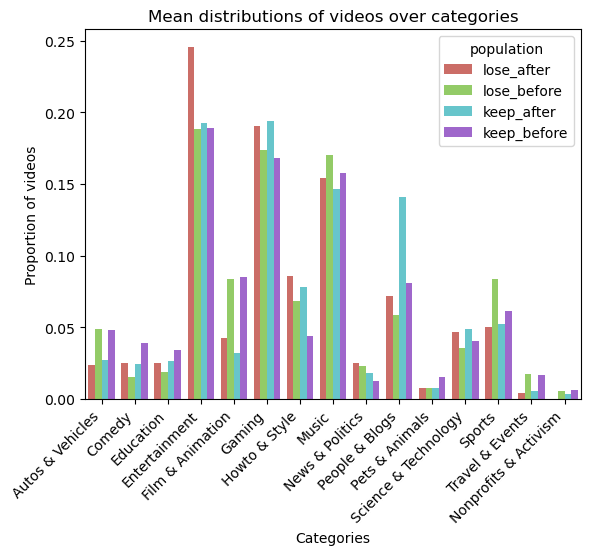

In [36]:
import seaborn as sns
video_distr_for_plotting = pd.concat(\
    [prop_videos_per_cat_l_a.mean(), prop_videos_per_cat_k_a.mean(), prop_videos_per_cat_l_b.mean(), prop_videos_per_cat_k_b.mean()], axis=1)\
    .rename(columns={0:"lose_after", 1:"lose_before", 2:"keep_after", 3:"keep_before"})

video_distr_for_plotting.reset_index(inplace=True)
video_distr_for_plotting = video_distr_for_plotting.melt('index', var_name='population', value_name='vals')

sns.barplot(data=video_distr_for_plotting, x="index", y="vals", hue="population", palette="hls")
plt.xticks(ticks = np.arange(0, len(categories)), labels = [cat.replace('categories_', '') for cat in video_distr_for_plotting["index"].unique()], rotation=45, ha="right");
plt.title("Mean distributions of videos over categories")
plt.ylabel("Proportion of videos")
plt.xlabel("Categories");

##### Statistical analysis of the distribution of videos over categories 

In [37]:
keep_fame_metavideos['before_fame'] = np.where(keep_fame_metavideos["upload_date"] > keep_fame_metavideos["max_growth_date"], 0, 1)
lose_fame_metavideos['before_fame'] = np.where(lose_fame_metavideos["upload_date"] > lose_fame_metavideos["max_growth_date"], 0, 1)
display(keep_fame_metavideos.sample(5))
keep_fame_metavideos.groupby("channel_id").count().shape

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,num_tags,max_growth_date,before_fame
29026,Music,UC9i9XG-O_VIkdcjVphrFJdg,2019-11-01 08:25:11.531033,NaN,0.0,WLjptzD8Bq8,280,3.0,NaN,Rufus Du Sol - No Place Live @ Solace Tour San...,2018-11-08 00:00:00,482.0,1,2019-04-22 00:00:00,1
36014,Sports,UC195ELzVDafwpukBRSJSMTw,2019-11-13 22:48:43.703631,#toddlersportfishing #experttackleau #aswblure...,1.0,Xxur3NYZFWU,117,42.0,"levibowman,fishing,3yearold,toddler,sportfishi...","3 year old catches massive salmon, music free ...",2019-05-20 00:00:00,1132.0,9,2019-04-22 01:00:00,0
25824,Gaming,UCEhZ8m5JUlcR16E6j3BUnjQ,2019-11-14 18:57:51.386847,Check out this amazing deal for the video game...,4.0,wCRX-5VFGcg,20899,158.0,"Youtube,Gaming,Live,Stream,Resident Evil,Silen...",Silent Hill 2: Director's Cut (PC),2018-09-06 00:00:00,2838.0,10,2018-08-13 00:00:00,0
33879,Gaming,UC5BHADReB4zxLgEgBnN626g,2019-11-22 02:34:24.462154,Donate to the Pixel Nation here guys and add y...,0.0,8D1RM1uxd74,6210,23.0,"Player Unkown's Battlegrounds,Battlegrounds,ba...",PLAYERUNKNOWN's BATTLEGROUNDS LIVE 🔴 BACK TO T...,2017-04-12 00:00:00,178.0,16,2019-05-20 00:00:00,1
7775,Gaming,UCf6J9yokPS0ys456jvjLBGQ,2019-11-11 15:53:29.457118,lanetSide 2 takes all the groundbreaking featu...,1.0,6DnyOWcjs1A,210,30.0,"Ps2,Planetside 2,gaming,video games,video game...",Planetside 2 - No Excuse,2012-07-26 00:00:00,1747.0,9,2019-06-03 00:00:00,1


(163, 14)

In [38]:
contingency_table_lose = {}
results_lose = {}
for channel in lose_fame_metavideos['channel_id'].unique():
    
    if channel in contingency_table_lose:
        continue
    else:
        df_of_channel = lose_fame_metavideos[lose_fame_metavideos["channel_id"] == f"{channel}"]
        
        contingency_table_lose[f"{channel}"] = pd.crosstab(df_of_channel["before_fame"], df_of_channel["categories"])
        chi2, p, dof, expected = scs.chi2_contingency(contingency_table_lose[f"{channel}"])
        results_lose[f"{channel}"] = [chi2, p, dof, expected]

In [39]:
# DUBBIO AMLETICO: categorie considerate TIENI A ZERO
count_lose = 0
for key in results_lose:
    if results_lose[key][1] < 0.05:
        count_lose += 1
        print(f"{key}: chi-stat {results_lose[key][0]} -- p-value {results_lose[key][1]}")

UCphO96ypf0z0ynM5r5rDF6w: chi-stat 9.04779411764706 -- p-value 0.010846671081649481
UCpci_E3rz6pTveUgZMF6Jjg: chi-stat 251.2441839431392 -- p-value 2.7734392127288478e-55
UCytLmyg_OJXmNkHEMS0w2Cw: chi-stat 103.90337409506981 -- p-value 1.4506037339594293e-21
UCmHr3gIlwwgdj_kVTcW-yqw: chi-stat 17.529384703852784 -- p-value 0.00015615017524861662
UCmBMoU5ZDb44zwp47g3AInA: chi-stat 95.62818646795733 -- p-value 1.305219005738976e-15
UCl_Ksy6Yi1b4eEZ46FInb_w: chi-stat 101.55612027836764 -- p-value 2.0518552022786443e-18
UCj-J4HHrtX3gT9ZEWqAf2Dw: chi-stat 299.6415502796173 -- p-value 1.1894531885294357e-64
UCiTtO9FDqPGRqDMuSC74AQA: chi-stat 717.6894077690513 -- p-value 1.4312821093447912e-156
UCiIfXQzQUTQtHSgb4ce247g: chi-stat 748.4816717466243 -- p-value 8.581066057461583e-165
UCh8g7gphDveEEF9aFMaI7ig: chi-stat 57.01551743527193 -- p-value 5.019851114231217e-11
UCgvVxB6GKYpyZY1Hh9u-uSQ: chi-stat 24.270289097875303 -- p-value 2.1935687880202468e-05
UCfZtRrsy5LSboUqhImk0Zuw: chi-stat 64.20042

In [40]:
contingency_table_keep = {}
results_keep = {}

for channel in keep_fame_metavideos['channel_id'].unique():
    if channel in contingency_table_keep:
        continue
    else:
        df_of_channel = keep_fame_metavideos[keep_fame_metavideos["channel_id"] == f"{channel}"]
        
        contingency_table_keep[f"{channel}"] = pd.crosstab(df_of_channel["before_fame"], df_of_channel["categories"])
        chi2, p, dof, expected = scs.chi2_contingency(contingency_table_keep[f"{channel}"])
        results_keep[f"{channel}"] = [chi2, p, dof, expected]


In [41]:
count_keep = 0
for key in results_keep:
    if results_keep[key][1] < 0.05:
        count_keep += 1
        print(f"{key}: chi-stat {results_keep[key][0]} -- p-value {results_keep[key][1]}")

UCzVnXCLWqY5dtOBn9UZoFTw: chi-stat 52.67738831145983 -- p-value 3.930907933725064e-13
UCzHN06NJR1ZXGn_YY3sCeMw: chi-stat 11.049126838235296 -- p-value 0.0008872897673155875
UCr-8JBJmj2eYXpGIgFzST1A: chi-stat 60.39669421487603 -- p-value 7.674047599313374e-14
UCpzp76Fc3fke3XVFx4SscyQ: chi-stat 235.7648709842789 -- p-value 4.503445093512759e-48
UCpXdkG4xYqj_aStgm3M1ylA: chi-stat 57.33408029878619 -- p-value 2.1806955486270462e-12
UCnPXXqyeVyFJQOe-Azs59mQ: chi-stat 211.5234375 -- p-value 6.389994855968624e-48
UCmjx5AHrD7OUZCVW8S2rvdQ: chi-stat 11.0525681492109 -- p-value 0.011444989440011393
UCk_nBvBjw0DuEtrT8Sxv5vA: chi-stat 53.15837104072398 -- p-value 2.8629014270339865e-12
UCj8rsEjT5V8Gi9Ps65p_i3w: chi-stat 16.611111111111114 -- p-value 0.00024714000611243285
UCitT48tHffPMf0UfYYizedQ: chi-stat 11.105303444505196 -- p-value 0.003877162442106955
UCidb8TVEeuYU5hIbKihD96A: chi-stat 6.441375830279433 -- p-value 0.011149226279644412
UChFFnw4EU_26F6SWiAR6ZUg: chi-stat 29.088888888888892 -- p

In [42]:
print(f"Number of \"lose\" videos that significantly changed their distribution over categories: {count_lose}")
print(f"Number of \"keep\" videos that significantly changed their distribution over categories: {count_keep}")

Number of "lose" videos that significantly changed their distribution over categories: 65
Number of "keep" videos that significantly changed their distribution over categories: 70


<font color = 'red'> HOW TO DO THE COMPARISON OF THE DISTRIBUTIONS OF THE DISTRIBUTIONS?

### Analysis within categories
<font color='green'> **TO DO**

In [85]:
categories_to_analyse = ["Entertainment", "Gaming", "Music"]


In [86]:
result = {}

for i in categories_to_analyse:
    dict_category = {}

    print(f"Category: {i}")
    
    # filter by category
    L_A_metavideos = lose_metavideos_after_sudden_growth[lose_metavideos_after_sudden_growth["categories"] == i]
    K_A_metavideos = keep_metavideos_after_sudden_growth[keep_metavideos_after_sudden_growth["categories"] == i]
    L_B_metavideos = lose_metavideos_before_sudden_growth[lose_metavideos_before_sudden_growth["categories"] == i]
    K_B_metavideos = keep_metavideos_before_sudden_growth[keep_metavideos_before_sudden_growth["categories"] == i]

    # select same channels
    channels_l_b = L_B_metavideos["channel_id"].unique()
    channels_l_a = L_A_metavideos["channel_id"].unique()
    index_lose = set.intersection(set(channels_l_b), set(channels_l_a))
    L_B_metavideos = L_B_metavideos[L_B_metavideos["channel_id"].isin(index_lose)]
    L_A_metavideos = L_A_metavideos[L_A_metavideos["channel_id"].isin(index_lose)]

    channels_k_b = K_B_metavideos["channel_id"].unique()
    channels_k_a = K_A_metavideos["channel_id"].unique()
    index_keep = set.intersection(set(channels_k_b), set(channels_k_a))
    K_B_metavideos = K_B_metavideos[K_B_metavideos["channel_id"].isin(index_keep)]
    K_A_metavideos = K_A_metavideos[K_A_metavideos["channel_id"].isin(index_keep)]

    # remove channels that don't have a match anymore
    removed_keep = matched_channels[~matched_channels["channel_keep"].isin(index_keep)]
    removed_lose = matched_channels[~matched_channels["channel_lose"].isin(index_lose)]
    index_remove = set.union(set(removed_keep["channel_lose"]), set(removed_lose["channel_keep"]))

    K_A_metavideos = K_A_metavideos[~K_A_metavideos["channel_id"].isin(index_remove)]
    K_B_metavideos = K_B_metavideos[~K_B_metavideos["channel_id"].isin(index_remove)]
    L_A_metavideos = L_A_metavideos[~L_A_metavideos["channel_id"].isin(index_remove)]
    L_B_metavideos = L_B_metavideos[~L_B_metavideos["channel_id"].isin(index_remove)]

    print(f"check shapes:   Lose After {L_A_metavideos.groupby('channel_id').count().shape} \
        Keep After {K_A_metavideos.groupby('channel_id').count().shape} \
        Lose before {L_B_metavideos.groupby('channel_id').count().shape} \
        Keep before {K_B_metavideos.groupby('channel_id').count().shape}")

    # filter time series dataframes
    L_ts = lose_fame_ts[lose_fame_ts["channel"].isin(L_A_metavideos["channel_id"])]
    K_ts = keep_fame_ts[keep_fame_ts["channel"].isin(K_A_metavideos["channel_id"])]

    # frequency of publication
    L_A_num_metavideos = L_A_metavideos.groupby("channel_id").count()['duration']
    K_A_num_metavideos = K_A_metavideos.groupby("channel_id").count()['duration']
    L_B_num_metavideos = L_B_metavideos.groupby("channel_id").count()['duration']
    K_B_num_metavideos = K_B_metavideos.groupby("channel_id").count()['duration']
   
    L_A_time = (L_ts.groupby("channel")['datetime'].max() - L_ts.groupby("channel")['max_growth_date'].mean()).dt.days
    K_A_time = (K_ts.groupby("channel")['datetime'].max() - K_ts.groupby("channel")['max_growth_date'].mean()).dt.days
    L_B_time = (L_ts.groupby("channel")['max_growth_date'].mean() - L_ts.groupby("channel")['datetime'].min()).dt.days
    K_B_time = (K_ts.groupby("channel")['max_growth_date'].mean() - K_ts.groupby("channel")['datetime'].min()).dt.days
    
    L_A_freq = L_A_num_metavideos / L_A_time
    K_A_freq = K_A_num_metavideos / K_A_time
    L_B_freq = L_B_num_metavideos / L_B_time
    K_B_freq = K_B_num_metavideos / K_B_time

    dict_category["freq_of_publication"] = {'L_A_freq': L_A_freq, 'K_A_freq': K_A_freq, 'L_B_freq': L_B_freq, 'K_B_freq': K_B_freq}

    # duration of videos
    L_A_duration = L_A_metavideos.groupby("channel_id").mean()['duration']
    K_A_duration = K_A_metavideos.groupby("channel_id").mean()['duration']
    L_B_duration = L_B_metavideos.groupby("channel_id").mean()['duration']
    K_B_duration = K_B_metavideos.groupby("channel_id").mean()['duration']

    dict_category["duration_of_videos"] = {'L_A_duration': L_A_duration, 'K_A_duration': K_A_duration, 'L_B_duration': L_B_duration, 'K_B_duration': K_B_duration}

    # number of tags
    L_A_num_tags = L_A_metavideos.groupby("channel_id").mean()['num_tags']
    K_A_num_tags = K_A_metavideos.groupby("channel_id").mean()['num_tags']
    L_B_num_tags = L_B_metavideos.groupby("channel_id").mean()['num_tags']
    K_B_num_tags = K_B_metavideos.groupby("channel_id").mean()['num_tags']

    dict_category["num_of_tags"] = {'L_A_num_tags': L_A_num_tags, 'K_A_num_tags': K_A_num_tags, 'L_B_num_tags': L_B_num_tags, 'K_B_num_tags': K_B_num_tags}

    result[i] = dict_category



Category: Entertainment
check shapes:   Lose After (9, 14)         Keep After (9, 14)         Lose before (9, 14)         Keep before (9, 14)
Category: Gaming
check shapes:   Lose After (8, 14)         Keep After (8, 14)         Lose before (8, 14)         Keep before (8, 14)
Category: Music
check shapes:   Lose After (9, 14)         Keep After (9, 14)         Lose before (9, 14)         Keep before (9, 14)


Statistical tests

In [87]:
for i in categories_to_analyse:
    print(f"Category: {i}\n")

    # frequency of publication tests
    print("Frequency of publication tests")
    # Keep videos
    stat, pval = scs.ttest_rel(result[i]["freq_of_publication"]["K_A_freq"], result[i]["freq_of_publication"]["K_B_freq"])
    print(f"    Keep videos: t-stat {stat} -- p-value {pval}")
    # Lose videos
    stat, pval = scs.ttest_rel(result[i]["freq_of_publication"]["L_A_freq"], result[i]["freq_of_publication"]["L_B_freq"])
    print(f"    Lose videos: t-stat {stat} -- p-value {pval}\n")

    # duration of videos tests
    print("Duration of videos tests")
    # Keep videos
    stat, pval = scs.ttest_rel(result[i]["duration_of_videos"]["K_A_duration"], result[i]["duration_of_videos"]["K_B_duration"])
    print(f"    Keep videos: t-stat {stat} -- p-value {pval}")
    # Lose videos
    stat, pval = scs.ttest_rel(result[i]["duration_of_videos"]["L_A_duration"], result[i]["duration_of_videos"]["L_B_duration"])
    print(f"    Lose videos: t-stat {stat} -- p-value {pval}\n")

    # number of tags tests
    print("Number of tags tests")
    # Keep videos
    stat, pval = scs.ttest_rel(result[i]["num_of_tags"]["K_A_num_tags"], result[i]["num_of_tags"]["K_B_num_tags"])
    print(f"    Keep videos: t-stat {stat} -- p-value {pval}")
    # Lose videos
    stat, pval = scs.ttest_rel(result[i]["num_of_tags"]["L_A_num_tags"], result[i]["num_of_tags"]["L_B_num_tags"])
    print(f"    Lose videos: t-stat {stat} -- p-value {pval}\n")

    print("--------------------------------------------------------------------------------------------------\n")


Category: Entertainment

Frequency of publication tests
    Keep videos: t-stat 1.2736565964666948 -- p-value 0.23854173221156447
    Lose videos: t-stat -0.7855464943247736 -- p-value 0.45476712106369943

Duration of videos tests
    Keep videos: t-stat 0.8953600203868469 -- p-value 0.39673421398241937
    Lose videos: t-stat 1.1882208469542634 -- p-value 0.2688219331515312

Number of tags tests
    Keep videos: t-stat -0.2798760759298054 -- p-value 0.7866728795007529
    Lose videos: t-stat 1.6576004476441546 -- p-value 0.13598605210941267

--------------------------------------------------------------------------------------------------

Category: Gaming

Frequency of publication tests
    Keep videos: t-stat -1.08300076999122 -- p-value 0.3146966177078874
    Lose videos: t-stat -1.015404950492678 -- p-value 0.3437171256274026

Duration of videos tests
    Keep videos: t-stat 1.3032301829200728 -- p-value 0.2337226781170435
    Lose videos: t-stat -0.7745449885055099 -- p-value 0.4